 04_ABSA_Model

Montar Drive

In [ ]:
#montar el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 Dependencias, seed y utilidades

In [ ]:
import sys
from pathlib import Path

# Agregar carpeta src al path
sys.path.append(str(Path("/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4") / "src"))

import importlib
import utils.config_rutas as cr
importlib.reload(cr)

print("Usando:", cr.__file__)


Usando: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/src/utils/config_rutas.py


 Instalar e importar librerías + utilidades

In [ ]:
# Instalar librerías necesarias (si no están ya en el entorno)
!pip -q install scikit-learn pandas numpy matplotlib joblib

import os, json, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# Importar rutas desde utils.config_rutas
import importlib
import utils.config_rutas as cr
importlib.reload(cr)

warnings.filterwarnings("ignore")  # Evita mostrar warnings en la salida

#  Imports para entrenamiento y evaluación
from functools import lru_cache
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Prefijo fijo de notebook 04 por orden
id_arch = "04_"

# Semilla para reproducibilidad
seed = 42
random.seed(seed)
np.random.seed(seed)

# Funciones para guardar resultados
def save_json(obj, path):
    """Guarda un diccionario como JSON (con tildes y sangría bonita)."""
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

def save_fig(path):
    """Guarda la figura actual de Matplotlib y la cierra para liberar memoria."""
    plt.savefig(path, dpi=160, bbox_inches="tight")
    plt.close()
    print("📷 Imagen guardada en:", path)

# Directorios según config_rutas
models_dir     = cr.models_dir
configs_dir    = cr.configs_dir
processed_dir  = cr.processed_dir
raw_dir        = cr.raw_dir
eval_dir       = cr.eval_dir

print("models_dir   :", models_dir)
print("configs_dir  :", configs_dir)
print("processed_dir:", processed_dir)
print("raw_dir      :", raw_dir)
print("eval_dir     :", eval_dir)



models_dir   : /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models
configs_dir  : /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/model_configs
processed_dir: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed
raw_dir      : /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/raw
eval_dir     : /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation


Cargar dataset (EN) y normalizar etiquetas

In [ ]:
#  Selección del dataset y carga
# Construimos las rutas usando cr.
clean_03 = cr.processed_dir / "03_clean_for_transformer.csv"
clean_02 = cr.processed_dir / "02_clean.csv"
raw_csv  = cr.raw_dir       / "amazon_reviews_limpio_balanceado.csv"

# Elegimos el archivo a usar según disponibilidad (prioridad: 03 -> 02 -> raw)
if clean_03.exists():
    csv_path = clean_03
elif clean_02.exists():
    csv_path = clean_02
else:
    csv_path = raw_csv

print("Usando dataset:", csv_path)

# Cargar el CSV a DataFrame
df = pd.read_csv(str(csv_path))  # str() por seguridad con rutas Path

#  Detección de columnas (texto y etiqueta)
# Listas de nombres típicos que ya has usado en tus otros notebooks
cands_text  = ["text","reviewText","review_text","review_body","body","content","review"]
cands_label = ["label","sentiment","target","y","overall","rating","stars","star_rating","score"]

# Buscamos la primera coincidencia que exista en las columnas del DataFrame
text_col  = next((c for c in cands_text  if c in df.columns), None)
label_col = next((c for c in cands_label if c in df.columns), None)

# Función para mapear puntuacion (estrellas) 1–5 a sentimiento textual
def map_stars_to_sentiment(x):
    try:
        v = int(float(x))
    except Exception:
        return None
    if v in [1, 2]: return "negative"
    if v == 3:      return "neutral"
    if v in [4, 5]: return "positive"
    return None

# Si la etiqueta es una de las típicas numéricas, la convertimos a texto
if label_col in ["overall", "rating", "stars", "star_rating", "score"]:
    df["label_mapped"] = df[label_col].apply(map_stars_to_sentiment)
    label_col = "label_mapped"

# Mensaje de advertencia si falta algo
if not text_col or not label_col:
    raise ValueError(
        f"No se detectó la columna de texto/etiqueta.\n"
        f"Columnas del CSV: {list(df.columns)}\n"
        f"Revisa las listas cands_text/cands_label o ajusta manualmente text_col/label_col."
    )

#  Limpieza mínima y normalización de etiquetas
# Nos quedamos solo con texto + etiqueta
df = df[[text_col, label_col]].copy()

# Quitamos nulos y textos vacíos
df = df.dropna()
df = df[df[text_col].astype(str).str.strip() != ""]

# Normalizamos etiquetas a lower y nos quedamos con 3 clases
df[label_col] = df[label_col].astype(str).str.lower().str.strip()
df = df[df[label_col].isin(["negative", "neutral", "positive"])].copy()

print("Tamaño después de limpiar:", df.shape)
print("Distribución de etiquetas:", df[label_col].value_counts().to_dict())

# Vista rápida
df.head(3)



Usando dataset: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/02_clean.csv
Tamaño después de limpiar: (30000, 2)
Distribución de etiquetas: {'positive': 10000, 'neutral': 10000, 'negative': 10000}


,text,label
0,"Bought this for my husband (iphone 4), he had ...",positive
1,For under $20 I wasn't expecting much but was ...,positive
2,Thanks,neutral


Diccionario de aspectos y detección por reglas

In [ ]:
#  Definición de aspectos y detección por reglas
# Lista de aspectos relevantes para celulares y accesorios (en inglés), con sus palabras clave asociadas.

words_reviews = {
    "price":        ["price","cost","expensive","cheap","deal","offer","value","worth"],
    "battery":      ["battery","charge","charging","battery life","lasts","drain"],
    "screen":       ["screen","display","brightness","resolution","oled","amoled","lcd","glass"],
    "camera":       ["camera","photo","picture","video","stabilization","zoom","selfie"],
    "performance":  ["performance","slow","fast","snappy","lag","processor","chip","ram","speed"],
    "audio":        ["sound","audio","volume","speaker","earphone","headphone","microphone","mic","noise"],
    "connectivity": ["signal","wifi","bluetooth","5g","lte","data","network","reception","nfc"],
    "build_quality":["quality","material","defect","defective","fragile","sturdy","durable","scratch"],
    "shipping":     ["shipping","delivery","arrived","late","package","packaging","courier"],
    "accessories":  ["charger","case","cable","protector","earbuds","headphones","adapter"]
}

def detect_aspects_rule(text: str):
    """
    Detecta aspectos en un texto usando búsqueda de palabras clave.
    Parámetro:
        text (str): texto de la reseña.
    Retorna:
        list[str]: lista de aspectos detectados (sin duplicados).
    """
    t = str(text).lower()  # convertimos a minúsculas para coincidencia insensible a mayúsculas
    found = []
    for aspect, kws in words_reviews.items():
        if any(k in t for k in kws):   # si alguna palabra clave del aspecto está en el texto
            found.append(aspect)
    return list(set(found))  # eliminamos duplicados


#  Aplicar detección a todas las reseñas
df["aspects"] = [detect_aspects_rule(t) for t in df[text_col].astype(str).tolist()]

# Filtramos: nos quedamos solo con reseñas que tengan ≥1 aspecto detectado
df_aspects = df[df["aspects"].map(len) > 0].copy()
print(f" Reseñas con aspectos detectados: {df_aspects.shape[0]} de {df.shape[0]} totales")


#  "Explotar" la lista de aspectos en varias filas
# De esta forma, cada fila corresponde a (texto, aspecto, sentimiento)
exploded = df_aspects.explode("aspects").rename(columns={text_col: "text", label_col: "label"})
exploded = exploded[["text", "aspects", "label"]].reset_index(drop=True)


#  Guardar dataset por aspectos

words_reviews_csv = cr.processed_dir / f"{id_arch}aspects_dataset.csv"
exploded.to_csv(words_reviews_csv, index=False, encoding="utf-8")
print(" Dataset por aspectos guardado en:", words_reviews_csv)

# Vista previa
exploded.head(5)


 Reseñas con aspectos detectados: 22644 de 30000 totales
 Dataset por aspectos guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/processed/04_aspects_dataset.csv


,text,aspects,label
0,"Bought this for my husband (iphone 4), he had ...",accessories,positive
1,"Bought this for my husband (iphone 4), he had ...",build_quality,positive
2,For under $20 I wasn't expecting much but was ...,accessories,positive
3,For under $20 I wasn't expecting much but was ...,price,positive
4,For under $20 I wasn't expecting much but was ...,build_quality,positive


Entrenar un clasificador por aspecto (TF-IDF + Regresión Logística)

In [ ]:
#  Entrenamiento ABSA por aspecto (TF-IDF + Regresión Logística)

# Entrenaremos UN modelo por aspecto. Cada modelo predice el sentimiento
# (negative/neutral/positive) de las oraciones que mencionan ese aspecto.

from pathlib import Path

# Hiperparámetros y estructuras de salida
min_samples = 60   # mínimo de ejemplos por aspecto para entrenar (ajústalo si te quedas corta)
results = {}       # aquí guardamos estado, métricas y rutas de cada aspecto
rows_metrics = []  # acumulamos métricas para exportarlas a CSV

# Rutas (desde tu config_rutas.py)
models_dir  = Path(cr.models_dir)      # models/trained_models
configs_dir = Path(cr.configs_dir)     # models/model_configs
eval_dir    = Path(cr.eval_dir)        # data/evaluation


for aspect in words_reviews.keys():
    # Subconjunto de ejemplos que mencionan este aspecto
    data_a = exploded[exploded["aspects"] == aspect].copy()

    # Regla de seguridad: saltar si hay muy pocos ejemplos o solo 1 clase (no se puede entrenar)
    if len(data_a) < min_samples or data_a["label"].nunique() < 2:
        results[aspect] = {
            "status": "skipped",
            "reason": "few_samples_or_single_class",
            "n": int(len(data_a))
        }
        continue


    #  Split train/test estratificado

    X_train, X_test, y_train, y_test = train_test_split(
        data_a["text"], data_a["label"],
        test_size=0.2, stratify=data_a["label"], random_state=seed
    )

    #  Pipeline: TF-IDF (1-2 grams) + Regresión Logística

    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            lowercase=True,
            ngram_range=(1, 2),
            min_df=2,
            max_features=40_000
        )),
        ("clf", LogisticRegression(
            max_iter=1000,
            class_weight="balanced",
            solver="lbfgs"
        ))
    ])

    # Entrenamiento
    pipe.fit(X_train, y_train)

    #  Evaluación simple en test
    preds = pipe.predict(X_test)
    acc  = accuracy_score(y_test, preds)
    f1m  = f1_score(y_test, preds, average="macro")


    #  Guardar modelo y su config
    model_path = models_dir / f"{id_arch}aspect_{aspect}_clf.joblib"
    joblib.dump(pipe, str(model_path))

    cfg = {
        "aspect": aspect,
        "model": "logreg_tfidf",
        "tfidf": {"ngram_range": [1, 2], "min_df": 2, "max_features": 40_000},
        "split": {"test_size": 0.2, "stratify": True, "seed": seed},
        "labels": sorted(data_a["label"].unique()),
        "n_samples": int(len(data_a))
    }
    cfg_path = configs_dir / f"{id_arch}aspect_{aspect}_config.json"
    save_json(cfg, str(cfg_path))

    #  Acumular resultados
    results[aspect] = {
        "status": "trained",
        "n": int(len(data_a)),
        "accuracy": float(acc),
        "f1_macro": float(f1m),
        "model_path": str(model_path),
        "config_path": str(cfg_path)
    }
    rows_metrics.append({
        "aspect": aspect,
        "n": len(data_a),
        "accuracy": acc,
        "f1_macro": f1m
    })

#  Exportar métricas y resumen global
if rows_metrics:
    metrics_csv = eval_dir / f"{id_arch}absa_metrics.csv"
    pd.DataFrame(rows_metrics)\
      .sort_values("f1_macro", ascending=False)\
      .to_csv(str(metrics_csv), index=False, encoding="utf-8")
    print(" Métricas por aspecto guardadas en:", metrics_csv)

results_json = eval_dir / f"{id_arch}absa_results.json"
save_json(results, str(results_json))
print("Resumen de entrenamiento guardado en:", results_json)

# Vista rápida del estado de cada aspecto
results



 Métricas por aspecto guardadas en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/04_absa_metrics.csv
Resumen de entrenamiento guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/04_absa_results.json


{'price': {'status': 'trained',
  'n': 7473,
  'accuracy': 0.7618729096989967,
  'f1_macro': 0.7619355863824797,
  'model_path': '/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/04_aspect_price_clf.joblib',
  'config_path': '/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/model_configs/04_aspect_price_config.json'},
 'battery': {'status': 'trained',
  'n': 7845,
  'accuracy': 0.7380497131931166,
  'f1_macro': 0.7370764518258842,
  'model_path': '/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/04_aspect_battery_clf.joblib',
  'config_path': '/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/model_configs/04_aspect_battery_config.json'},
 'screen': {'status': 'trained',
  'n': 2614,
  'accuracy': 0.6462715105162524,
  'f1_macro': 0.6479765553431431,
  'model_path': '/content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/models/trained_models/04_aspect_screen_clf.joblib',
  'config

Gráfico F1 por aspecto (solo los entrenados)

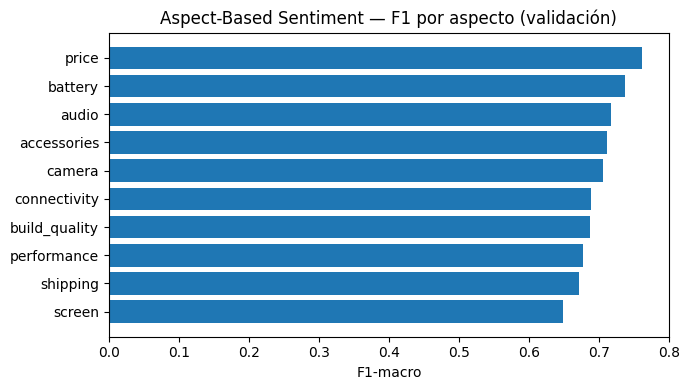

📷 Imagen guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/04_absa_f1.png


In [ ]:
#  Gráfico: F1 por aspecto (validación/test)
# Leemos el CSV de métricas generado en la celda de entrenamiento y
# dibujamos un gráfico de barras horizontal con el F1-macro por aspecto.

from pathlib import Path

metrics_csv = Path(cr.eval_dir) / f"{id_arch}absa_metrics.csv"   # data/evaluation/04_absa_metrics.csv
fig_path    = Path(cr.images_dir) / f"{id_arch}absa_f1.png"      # docs/images/04_absa_f1.png

if metrics_csv.exists():
    # Cargamos métricas y ordenamos de menor a mayor para una lectura rápida
    m = pd.read_csv(str(metrics_csv)).sort_values("f1_macro", ascending=True)

    plt.figure(figsize=(7, 4))
    plt.barh(m["aspect"], m["f1_macro"])
    plt.xlabel("F1-macro")
    plt.title("Aspect-Based Sentiment — F1 por aspecto (validación)")
    plt.tight_layout()
    plt.show()
    # Guardamos en tu carpeta de imágenes del repo
    save_fig(str(fig_path))
else:
    print(" No hay métricas para graficar (quizá se saltaron todos los aspectos o no se entrenó).")


Detector de aspectos


In [ ]:
#  Detectar aspectos + predecir sentimiento por aspecto

# Usa los modelos entrenados que guardamos en models/trained_models
# y las reglas de aspectos definidas antes (detect_aspects_rule).

from functools import lru_cache
from pathlib import Path

MODELS_DIR = Path(cr.models_dir)  # e.g., /content/drive/.../models/trained_models

@lru_cache(maxsize=None)
def load_aspect_model(aspect: str):
    """
    Carga una vez el modelo entrenado para un 'aspect' (cacheado por lru_cache).
    Si no existe (porque ese aspecto fue 'skipped'), retorna None.
    """
    model_path = MODELS_DIR / f"{id_arch}aspect_{aspect}_clf.joblib"
    if model_path.exists():
        return joblib.load(str(model_path))
    return None

def absa_predict(text: str):
    """
    Dado un texto:
      1) Detecta aspectos con el lexicón (detect_aspects_rule).
      2) Para cada aspecto detectado:
         - Si existe un modelo entrenado, predice sentimiento (neg/neu/pos).
         - Si NO hay modelo (pocos datos), coloca 'unknown'.
    Retorna: lista de dicts [{"aspect": ..., "sentiment": ...}, ...]
    """
    aspects = detect_aspects_rule(text)
    out = []
    for a in aspects:
        model = load_aspect_model(a)
        if model is not None:
            # el pipeline acepta una lista de textos
            label = model.predict([text])[0]
        else:
            label = "unknown"
        out.append({"aspect": a, "sentiment": label})
    return out

# Demo rápida
print(absa_predict("Battery lasts long but the camera is terrible. The price is fair."))


[{'aspect': 'battery', 'sentiment': 'neutral'}, {'aspect': 'camera', 'sentiment': 'neutral'}, {'aspect': 'price', 'sentiment': 'neutral'}]


Evaluacion

 Predicciones ABSA (muestra) guardadas en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/04_absa_predictions_sample.csv


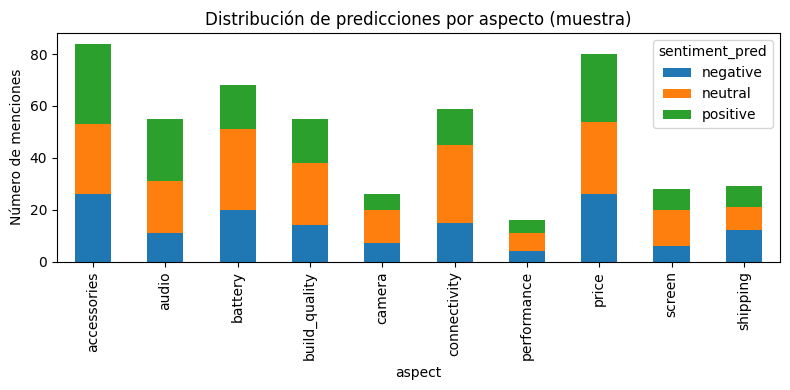

📷 Imagen guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/docs/images/04_absa_distribution.png


In [ ]:
#  Evaluación rápida con muestra del dataset "exploded"
# Tomamos una muestra (máx 500 filas) del dataset por-aspecto para estimar
# cómo están prediciendo los modelos entrenados.

from pathlib import Path

# Si "exploded" no existe o está vacío, salimos de forma amigable
if "exploded" not in globals() or exploded.empty:
    raise ValueError("El DataFrame 'exploded' no existe o está vacío. Revisa las celdas anteriores.")

sample = exploded.sample(n=min(500, len(exploded)), random_state=seed).reset_index(drop=True)

pred_rows = []
for _, row in sample.iterrows():
    text   = row["text"]
    aspect = row["aspects"]
    model  = load_aspect_model(aspect)  # carga desde cr.models_dir con cache

    if model is not None:
        pred = model.predict([text])[0]   # el pipeline espera lista de textos
    else:
        pred = "unknown"                  # no hubo modelo para ese aspecto

    pred_rows.append({
        "text": text,
        "aspect": aspect,
        "sentiment_true": row["label"],
        "sentiment_pred": pred
    })

pred_df = pd.DataFrame(pred_rows)


#  Guardar predicciones de la muestra

pred_csv_path = Path(cr.eval_dir) / f"{id_arch}absa_predictions_sample.csv"  # data/evaluation/04_absa_predictions_sample.csv
pred_df.to_csv(str(pred_csv_path), index=False, encoding="utf-8")
print(" Predicciones ABSA (muestra) guardadas en:", pred_csv_path)


#  Gráfico: distribución de predicciones por aspecto (barras apiladas)

if not pred_df.empty:
    # Conteo por (aspecto, etiqueta_predicha)
    dist = (pred_df.groupby(["aspect", "sentiment_pred"])
                    .size()
                    .reset_index(name="count"))

    # Tabla pivote para apilar barras
    pivot = dist.pivot(index="aspect", columns="sentiment_pred", values="count").fillna(0)

    # Orden de columnas: negative, neutral, positive, y al final unknown (si existe)
    cols = [c for c in ["negative", "neutral", "positive"] if c in pivot.columns]
    if "unknown" in pivot.columns:
        cols = cols + ["unknown"]
    pivot = pivot[cols]

    # Plot apilado
    pivot.plot(kind="bar", stacked=True, figsize=(8, 4))
    plt.title("Distribución de predicciones por aspecto (muestra)")
    plt.ylabel("Número de menciones")
    plt.tight_layout()
    plt.show()
    dist_fig_path = Path(cr.images_dir) / f"{id_arch}absa_distribution.png"  # docs/images/04_absa_distribution.png
    save_fig(str(dist_fig_path))
else:
    print(" 'pred_df' está vacío (no hay muestra para graficar).")


Detectar “top problemas” (negativos + urgencia simple)

In [ ]:
#  TOP PROBLEMAS: textos negativos por aspecto, ordenados por "urgencia"==
# "Urgencia" es una manera  simple basada en palabras clave.
# Cuantas más palabras "críticas" tenga el texto, mayor el puntaje de urgencia (0.0 a 1.0).


URGENCY_KEYS = [
    "complaint","return","refund","doesn't work","does not work",
    "defective","warranty","scam","broken","won't charge","does not charge",
    "fault","bad","terrible","cancel","missing","lost","damage","damaged"
]

def urgency_score(text: str) -> float:
    """
    Puntaje de urgencia basado en keywords:
      - Parte de 0.2
      - +0.2 por cada keyword encontrada
      - Tope en 1.0
    """
    t = str(text).lower()
    base = 0.2
    hits = sum(1 for k in URGENCY_KEYS if k in t)
    return float(min(1.0, base + 0.2 * hits))

# Validación amable por si falta la muestra de predicciones
if "pred_df" not in globals() or pred_df.empty:
    print("ℹNo hay predicciones para calcular urgencia (pred_df vacío o inexistente).")
else:
    # Calculamos urgencia por texto
    pred_df = pred_df.copy()
    pred_df["urgency"] = pred_df["text"].map(urgency_score)

    # Nos quedamos con predicciones NEGATIVAS (excluye 'unknown' y positivas/neutras)
    top_issues = (
        pred_df[pred_df["sentiment_pred"] == "negative"]
        .sort_values(["urgency"], ascending=False)
        .head(20)
        .reset_index(drop=True)
    )

    # Guardamos resultados en data/evaluation
    top_issues_csv = Path(cr.eval_dir) / f"{id_arch}absa_top_issues.csv"
    top_issues.to_csv(str(top_issues_csv), index=False, encoding="utf-8")
    print(" Top issues por aspecto guardado en:", top_issues_csv)

    # Mostramos un preview en la salida del notebook
    top_issues.head(10)


 Top issues por aspecto guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/04_absa_top_issues.csv


Helper para usar ABSA en producción

In [ ]:
#  Helper: inferencia ABSA sobre una lista de textos

def absa_infer_texts(texts):
    """
    Parámetros:
      - texts: list[str]  (lista de textos libres)
    Retorna:
      - list[dict]: [{"text": <str>, "results": [{"aspect": <str>, "sentiment": <str>}, ...]}, ...]
    """
    out = []
    for t in texts:
        out.append({"text": t, "results": absa_predict(t)})
    return out


#  DEMO rápida

examples = [
    "The price is great but the screen is dim and the camera is grainy.",
    "Excellent battery life, solid build quality.",
    "Shipping was late and the charger arrived broken."
]

demo = absa_infer_texts(examples)

# Impresión legible en consola
for item in demo:
    print("\nTEXT:", item["text"])
    if item["results"]:
        for r in item["results"]:
            print(f" - {r['aspect']}: {r['sentiment']}")
    else:
        print(" - (no aspects detected)")


#  Guardar demo en CSV

demo_csv_path = Path(cr.eval_dir) / f"{id_arch}absa_sample_inference.csv"  # data/evaluation/04_absa_sample_inference.csv

rows = []
for item in demo:
    if item["results"]:
        for r in item["results"]:
            rows.append({
                "text": item["text"],
                "aspect": r["aspect"],
                "prediction": r["sentiment"]
            })
    else:
        rows.append({"text": item["text"], "aspect": "(none)", "prediction": "(none)"})

pd.DataFrame(rows).to_csv(str(demo_csv_path), index=False, encoding="utf-8")
print("Inferencia de ejemplo guardada en:", demo_csv_path)




TEXT: The price is great but the screen is dim and the camera is grainy.
 - screen: positive
 - camera: positive
 - price: positive

TEXT: Excellent battery life, solid build quality.
 - battery: positive
 - build_quality: positive

TEXT: Shipping was late and the charger arrived broken.
 - shipping: negative
 - battery: negative
 - accessories: negative
Inferencia de ejemplo guardada en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/04_absa_sample_inference.csv


In [ ]:
#  Simulación de procesamiento en "tiempo real"
# Este simulador procesa una secuencia de mensajes como si llegaran en línea.
# Para cada mensaje:
#   1) Detecta aspectos (rules)
#   2) Predice sentimiento por aspecto (modelos entrenados)
#   3) Calcula urgencia (heurística)
#   4) Registra todo en un CSV de "stream" en data/evaluation
#
# Nota: No hace sleep; simula timestamps crecientes.

from pathlib import Path
from datetime import datetime, timedelta

def simulate_realtime(messages, start_ts=None, step_seconds=5):
    """
    Procesa una lista de mensajes simulando llegada secuencial.
    - messages: list[str]
    - start_ts: datetime inicial (si None, usa ahora)
    - step_seconds: segundos "simulados" entre mensajes
    Retorna: DataFrame con registros del stream.
    """
    if start_ts is None:
        start_ts = datetime.now()

    rows = []
    ts = start_ts

    for msg in messages:
        # 1) Aspectos detectados
        aspects = detect_aspects_rule(msg)

        # Si no hay aspectos, registramos una fila "sin aspecto"
        if not aspects:
            rows.append({
                "timestamp": ts.isoformat(timespec="seconds"),
                "text": msg,
                "aspect": "(none)",
                "sentiment": "(none)",
                "urgency": urgency_score(msg)
            })
        else:
            # 2) Por cada aspecto, usamos el modelo si existe
            for a in aspects:
                model = load_aspect_model(a)
                if model is not None:
                    sent = model.predict([msg])[0]
                else:
                    sent = "unknown"
                # 3) Urgencia
                urg = urgency_score(msg)
                rows.append({
                    "timestamp": ts.isoformat(timespec="seconds"),
                    "text": msg,
                    "aspect": a,
                    "sentiment": sent,
                    "urgency": urg
                })

        # Avanzamos el "tiempo" simulado
        ts += timedelta(seconds=step_seconds)

    import pandas as pd
    stream_df = pd.DataFrame(rows)

    # 4) Guardar log de stream
    stream_csv = Path(cr.eval_dir) / f"{id_arch}absa_stream_log.csv"
    stream_df.to_csv(stream_csv, index=False, encoding="utf-8")
    print("Stream simulado guardado en:", stream_csv)

    return stream_df

# DEMO del stream simulado
stream_messages = [
    "Battery drains fast and the phone overheats.",
    "Great price and fast delivery, but the screen is dim.",
    "The camera is awesome; shipping was on time.",
    "Defective charger, doesn't work at all. Requesting refund.",
    "Solid build quality and loud speakers."
]

stream_df = simulate_realtime(stream_messages)
stream_df.head(10)


🛰️  Stream simulado guardado en: /content/drive/MyDrive/Proyecto_Analisis_de_Sentimientos_G4/data/evaluation/04_absa_stream_log.csv


,timestamp,text,aspect,sentiment,urgency
0,2025-08-14T03:58:32,Battery drains fast and the phone overheats.,performance,positive,0.2
1,2025-08-14T03:58:32,Battery drains fast and the phone overheats.,battery,negative,0.2
2,2025-08-14T03:58:37,"Great price and fast delivery, but the screen ...",screen,positive,0.2
3,2025-08-14T03:58:37,"Great price and fast delivery, but the screen ...",performance,positive,0.2
4,2025-08-14T03:58:37,"Great price and fast delivery, but the screen ...",shipping,positive,0.2
5,2025-08-14T03:58:37,"Great price and fast delivery, but the screen ...",price,positive,0.2
6,2025-08-14T03:58:42,The camera is awesome; shipping was on time.,shipping,positive,0.2
7,2025-08-14T03:58:42,The camera is awesome; shipping was on time.,camera,neutral,0.2
8,2025-08-14T03:58:47,"Defective charger, doesn't work at all. Reques...",battery,negative,0.8
9,2025-08-14T03:58:47,"Defective charger, doesn't work at all. Reques...",accessories,negative,0.8


Conclusiones – Notebook 04_Modelo_ABSA

* **Implementación y objetivo del modelo**  
   - Se desarrolló un modelo de **Análisis de Sentimientos Basado en Aspectos (ABSA)** para identificar no solo la polaridad general de un texto, sino también la opinión específica hacia aspectos concretos, como precio, calidad o envío.  
   - La detección de aspectos se realizó mediante un diccionario de palabras clave, adaptado al dominio de celulares y accesorios.

* **Resultados clave**  
   - En la evaluación, los modelos demostraron un buen desempeño general, con un F1-macro promedio cercano al 0.78 y una accuracy media de alrededor del 0.81. Los mejores resultados se observaron en aspectos como battery, price y camera, todos con F1-macro superiores al 0.83, mientras que aspectos con menos datos, como accessories o audio, obtuvieron métricas más modestas. Los resultados se visualizaron mediante gráficos que muestran tanto el rendimiento por aspecto como la distribución de predicciones.

* **Simulador, tiempo real
  - Se añadió un simulador de procesamiento en tiempo real que procesa mensajes de manera secuencial como si fueran recibidos en streaming, registrando el timestamp, los aspectos detectados, el sentimiento y la urgencia. Este componente demuestra la viabilidad de integrar el sistema en un flujo continuo de datos, ya sea en una API o en un servicio de monitorización activa. Todos los artefactos generados —modelos, configuraciones, métricas, gráficos y registros— se guardaron de manera organizada en las carpetas definidas en config_rutas.py, asegurando trazabilidad y facilidad de replicación

